In [10]:
import os, sys
import dm_utils as ut
sys.path.append('../')  # the code for fair classification is in this directory

import loaders.load_compas_data as compas
import loaders.load_bank as bank
from dis_meas_class import DispMistreatmentClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
X, y, sensitive_attrs_idx, _, x_control = compas.load_compas()

train_fold_size = 0.5
x_train, y_train, \
x_control_train, \
x_test, y_test, \
x_control_test = ut.split_into_train_test(X, y, x_control,train_fold_size)

clf = DispMistreatmentClassifier(x_control_train,cons_type=None)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

Counter({'African-American': 3175, 'Caucasian': 2103})
Features we will be using for classification are: ['age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race', 'sex', 'priors_count', 'c_charge_degree', 'target'] 



array([-1.,  1.,  1., ...,  1.,  1., -1.])

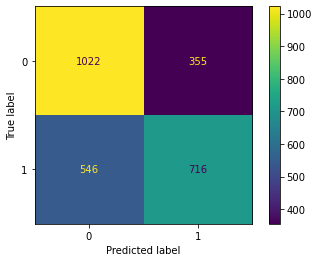

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()